In [24]:
%matplotlib inline


NLP: Классификация фамилий с использованием рекуррентных нейронных сетей (RNN)
**************************************************************
**Автор идеи**: `Sean Robertson 

В этом демонстрационном проекте реализована RNN для классификации слов, обученная на предварительно
обработанных данных для моделирования NLP-моделей “с нуля”, без использования удобных функций
, таких как `torchtext`, с целью формирования представления о препроцессенге для NLP на низком уровне.

RNN считывает слова как серию символов, выдавая предсказание и скрытое состояние на каждом шаге,
после завершения всех шагов принимается конечное предсказание за выход, т.е. к какому классу принадлежит слово.

RNN обучена на нескольких тысячах фамилий из 18 языков мира (происхождения), и предсказывает, к какому языку относится фамилия, на основе орфографии:


::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch

.. Примечание::

   Данные со списками фамилий можно загрузить здесь:
   <https://download.pytorch.org/tutorial/data.zip>.

В директории ``data/names`` находятся 18 текстовых файлов, названных как
"[Language].txt". Каждый файл содержит списки фамилий, по одной фамилии на строке,
в основном в формате Unicode.

In [26]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# преобразование формата Unicode в ASCII, для справки https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# построение словаря со списком фамилий для каждого языка
category_lines = {}
all_categories = []

# чтение и разбиение файлов на строки
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


Теперь у нас есть``category_lines``, словарь, отображающий каждую категорию (язык) со списком строк (фамилий).
Мы также сохранили ``all_categories``  (просто список языков) и ``n_categories`` для последующего использования.




In [27]:
print(category_lines['Russian'][:5])

['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin']


Превращение имен в тензоры
--------------------------

Теперь, когда мы упорядочили все имена, нам нужно превратить их в тензоры, чтобы использовать их.

Для представления одной буквы мы используем "однобуквенный вектор" размером
``<1 x n_letters>``. Однобуквенный вектор заполнен 0, за исключением 1 в индексе текущей буквы, 
например, ``"b" = <0 1 0 0 0 ...>``.

Чтобы составить слово, мы объединяем их в двумерную матрицу 
``<line_length x 1 x n_letters>``.

Это дополнительное первое измерение связано с тем, что PyTorch предполагает, что все происходит 
пакетно - здесь мы просто используем размер пакета 1.




In [28]:
import torch

# Найти индекс буквы из всех_букв, например, "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Для наглядности превратим букву в <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Превратите строку в <line_length x 1 x n_letters>,
# или массив однобуквенных векторов
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('L'))

print(lineToTensor('Loverberg').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([9, 1, 57])


In [49]:
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

Создание RNN
====================

До появления автоматической дифференциации, создание рекуррентной нейронной сети в Torch заключалось в клонировании параметров слоя в течение нескольких временных интервалов. Слои содержали скрытое состояние и градиенты, которые теперь полностью обрабатываются самим графом. Это означает, что вы можете реализовать RNN в очень "чистом" виде, как обычные слои с прямой передачей.


Этот модуль RNN скопирован из учебника PyTorch
tutorial <https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html, это всего лишь 2 линейных слоя, которые работают с входом и скрытым состоянием, а также слой LogSoftmax после выхода.

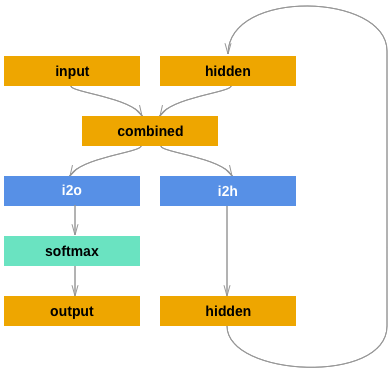



In [29]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

Чтобы запустить шаг этой сети, нам нужно передать вход (в нашем случае тензор для текущей буквы) и предыдущее скрытое состояние (которое мы сначала инициализируем нулями). Мы получим обратно выход (вероятность каждого языка) и следующее скрытое состояние (которое мы сохраним для следующего шага).

In [30]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

В целях эффективности мы не хотим создавать новый тензор для каждого шага, поэтому мы будем использовать lineToTensor вместо letterToTensor и использовать срезы. Это оптимизирует использование ресурсов, предварительно вычисляя партии тензоров.


In [31]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9264, -2.9891, -2.8829, -2.9172, -2.9531, -2.8671, -2.9541, -2.8658,
         -2.8370, -2.7897, -2.9161, -2.7901, -3.0248, -2.7977, -2.8643, -2.8676,
         -2.9566, -2.8657]], grad_fn=<LogSoftmaxBackward0>)


Результатом является тензор <1 x n_categories>, где каждый элемент является вероятностью данной категории (чем выше, тем вероятнее).

Обучение¶
========
Подготовка к обучению
----------------------

Прежде чем приступить к обучению, мы должны сделать несколько вспомогательных функций. Первая - интерпретировать выход сети, который, как мы знаем, является вероятностью каждой категории. Мы можем использовать Tensor.topk, чтобы получить индекс наибольшего значения:





In [32]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Italian', 9)


Нам также нужен быстрый способ получения учебного экземпляра (фамилия и его язык):



In [33]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Sleiman
category = Chinese / line = Lai
category = Italian / line = Zeni
category = Korean / line = Chong
category = Japanese / line = Hotta
category = Korean / line = Tsai 
category = Dutch / line = Ter Avest
category = Russian / line = Markhinin
category = Greek / line = Demas
category = English / line = Fitchett


Обучение сети
--------------------

Теперь, чтобы обучить эту сеть, достаточно показать ей множество примеров, получить предсказания и штрафовать, если она ошибается.

Для функции потерь подходит ``nn.NLLLoss`` так как последний
слой RNN - ``nn.LogSoftmax``.

In [34]:
criterion = nn.NLLLoss()

Каждый цикл обучения будет:

- Создавать входной и целевой тензоры
- Создавать обнуленное начальное скрытое состояние
- Считывать каждую букву и

   - Сохранять скрытое состояние для следующей буквы

- Сравнивать конечный результат с целевым
- Активировать алгоитм обратного распространения ошибки 
- Возвращать выход


In [35]:
learning_rate = 0.005 # коэффициент обучения нуждается в тонкой настройке

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Добавить градиенты параметров к их значениям, умноженным на скорость обучения
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Теперь нам осталось запустить эту функцию на множестве примеров. Поскольку функция train возвращает и выход, и потери, мы можем вывести ее результаты, а также отслеживать потери для построения графика. 



In [36]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# лог потерь, используем для построения графика обучения
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Печать номера итерации, поторь, экземпляр и предсказание
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Добавить текущее среднее значение потерь в список
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.6467 Moon / Irish ✗ (Korean)
10000 10% (0m 13s) 2.8408 Testa / Japanese ✗ (Italian)
15000 15% (0m 20s) 1.8404 Hayashi / Arabic ✗ (Japanese)
20000 20% (0m 27s) 2.4177 Murphy / Arabic ✗ (Scottish)
25000 25% (0m 33s) 2.4723 Casey / Arabic ✗ (Irish)
30000 30% (0m 41s) 2.9460 Wolff / Czech ✗ (German)
35000 35% (0m 49s) 6.2648 Macdermott / Italian ✗ (Irish)
40000 40% (0m 56s) 4.5647 Mas / Chinese ✗ (Dutch)
45000 45% (1m 4s) 1.1647 Acker / German ✓
50000 50% (1m 11s) 0.2095 Kozlow / Polish ✓
55000 55% (1m 18s) 1.2202 Khoo / Korean ✗ (Chinese)
60000 60% (1m 26s) 2.9475 Bains / Greek ✗ (English)
65000 65% (1m 33s) 1.0520 Bermudez / Spanish ✓
70000 70% (1m 41s) 0.6314 Pereira / Portuguese ✓
75000 75% (1m 49s) 1.5618 Liao / Vietnamese ✗ (Chinese)
80000 80% (1m 57s) 1.3559 Rojo / Spanish ✓
85000 85% (2m 4s) 0.5919 Hoang / Vietnamese ✓
90000 90% (2m 12s) 5.1534 Sip / Korean ✗ (Czech)
95000 95% (2m 20s) 0.7368 Tron / Vietnamese ✓
100000 100% (2m 27s) 0.8417 Clifford / English ✓


Отображение результатов обучения
--------------------

Визуализация обучения модели от списка ``all_losses``

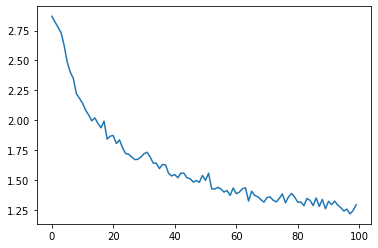

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Оценка результатов
======================

Чтобы увидеть, насколько хорошо сеть справляется с различными категориями, мы создадим матрицу ошибок, указывающую для каждого фактического языка (строки), какой язык угадала сеть (столбцы). Для расчета матрицы ошибок множество образцов прогоняется через сеть с помощью функции ``evaluate()``, которая аналогична функции ``train()`` за вычетом backprop.

<ipython-input-38-85a8518edfdf>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-38-85a8518edfdf>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


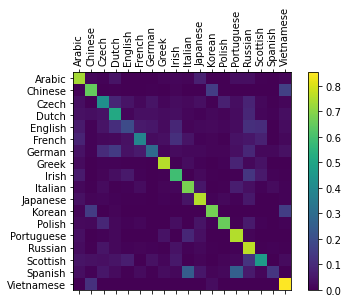

In [38]:
# Отслеживайте результатов 
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Просто возвращаем выход 
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Проверка результатов с отражением ошибок сети
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Нормализация путем деления каждой строки на ее сумму
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Создаем рисунок
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Настраиваем оси
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Добавляем примечания
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# шоу
plt.show()

Яркие пятна на главной оси, свидетельствуют о бОльших ошибках сети, например, китайский для корейского, и испанский для итальянского. Похоже, что сеть очень хорошо справляется с греческим и очень плохо с английским (возможно, из-за совпадения с другими языками).


Работа в режиме пользователя
---------------------




In [39]:
# Добавляем транслитер для русского языка
from translate import Translator
translator = Translator(from_lang="russian",to_lang="english")

# Функция предсказания
def predict(input_line, n_predictions=3):
    input_line = translator.translate(input_line)
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [40]:
predict('Рогозин')
predict('Лавров')
predict('Шойгу')


> Rogozin
(-0.73) Dutch
(-1.41) Irish
(-2.59) Scottish

> Lavrov
(-0.66) Russian
(-1.38) Portuguese
(-2.71) French

> Shoigu
(-0.86) Arabic
(-1.27) Japanese
(-2.25) Irish


Сохранение модели
======================

В большинстве случаев модель машинного обучения в Python будет храниться в памяти как объект Python во время выполнения кода, а затем будет удалена после окончания работы программы. Если бы мы могли сохранить этот объект на жестком диске сразу после того, как модель обучится, то в следующий раз, когда нам понадобится сделать прогноз, мы сможем просто загрузить готовую модель в память и не проходить этапы инициализации и обучения. В информатике процесс преобразования объекта в поток байтов для хранения называется сериализацией. В Python это может быть легко реализовано с помощью пакета под названием pickle, который изначально имеет нативную поддержку Python. Python-разработчики еще называют «pickling» процесс сериализации объекта с помощью pickle.

In [45]:
torch.save(rnn.state_dict(), './model_rnn')